## I_org - Organization Index

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import scipy
import skimage.measure as skm

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [2]:
from plotFuncs import *

In [3]:
variable = 'precip'

models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]

observations = [
    # 'GPCP'
    ]

datasets = models + observations

resolutions = [
    # 'original',
    'regridded'
    ]

experiments =[
    'historical',
    # 'rcp85'
    ]


print('variable:{}, dataset:{}, experiment:{}, resolution:{}'.format(variable, datasets[0], experiments[0], resolutions[0]))
ds = get_dsvariable(variable, datasets[0], experiments[0], resolution=resolutions[0])
ds

variable:precip, dataset:GFDL-CM3, experiment:historical, resolution:regridded


<xarray.Dataset>
Dimensions:  (time: 10950, lat: 22, lon: 128)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes: (12/27)
    title:                  NOAA GFDL GFDL-CM3, historical (run 1) experiment...
    institute_id:           NOAA GFDL
    source:                 GFDL-CM3 2010 atmosphere: AM3 (AM3p9,C48L48); sea...
    contact:                gfdl.climate.model.info@noaa.gov
    project_id:             CMIP5
    table_id:               Table day (31 Jan 2011)
    ...                     ...
    parent_experiment_id:   piControl
    physics_version:        1
    product:                output1
    institution:            NOAA GFDL(201 Forrestal Rd, Princeton, NJ, 08540)
    history:                File was processed by fremetar (GFDL analog of CM...
    parent_experiment_rip:  r1i1p1

In [30]:
rome = get_metric('rome', datasets[0], experiments[0], resolution=resolutions[0])
rome

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    rome     (time) float64 ...
    rome_n   (time) float64 ...
Attributes:
    description:  ROME based on all and the 8 largest contiguous convective r...
    units:        km^2

In [32]:
rome_threshold = 99.9
rome_prctile = np.percentile(rome['rome'],rome_threshold)
x_rome= np.squeeze(np.argwhere(rome['rome'].data>=rome_prctile))
x_rome

array([1861, 1925, 3714, 3718, 3719, 3721, 3723, 9897, 9917, 9918, 9919])

In [45]:
scene = ds[variable].isel(time=1)
scene

<xarray.DataArray 'precip' (lat: 22, lon: 128)>
array([[5.208645e-01, 5.286952e-01, 4.838056e-01, ..., 5.202030e-01,
        4.441906e-01, 4.295749e-01],
       [4.386893e-01, 4.056462e-01, 2.819712e-01, ..., 4.922635e-01,
        3.515040e-01, 3.771245e-01],
       [5.001513e-01, 4.252303e-01, 1.989651e-01, ..., 4.043370e-01,
        3.452402e-01, 4.430559e-01],
       ...,
       [1.161515e-04, 9.051974e-05, 7.923597e-08, ..., 0.000000e+00,
        4.676280e-09, 1.302459e-08],
       [5.918877e-09, 1.046601e-07, 4.550305e-08, ..., 5.499214e-11,
        4.128244e-10, 3.838583e-10],
       [5.142317e-05, 8.186013e-06, 3.491360e-10, ..., 6.036810e-05,
        4.145062e-04, 3.846406e-04]], dtype=float32)
Coordinates:
    time     object 1970-01-02 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    regrid_method:  conservative
    units:          mm day⁻¹

In [5]:
conv_threshold = get_metric('prPercentiles', datasets[0], experiments[0])['pr97'].mean(dim=('time'))

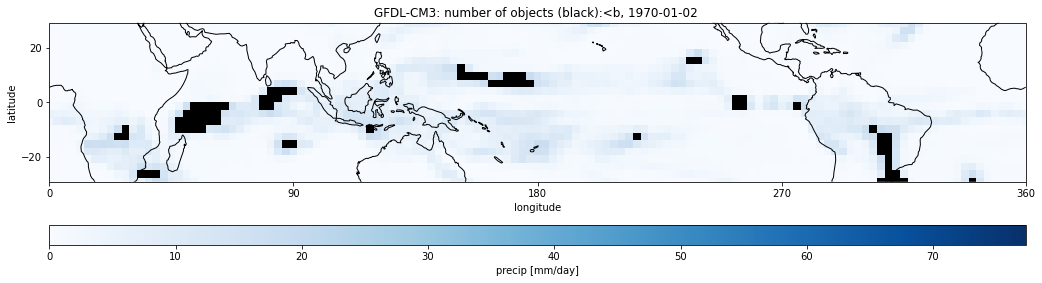

In [48]:
lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
obj = (obj>0)*1
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)


fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues') #, vmin=10, vmax=50)
ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

ax.set_title(datasets[0] + ': number of objects (black):' + str(ds.isel(time=0).values)[:2] + ', ' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precip' + ' [mm/day]')

In [281]:
# calculate first on artificial field
artScenes = xr.zeros_like(scene) 
artScenes

<xarray.DataArray 'precip' (lat: 22, lon: 128)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time     object 1970-01-01 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    regrid_method:  conservative
    units:          mm day⁻¹

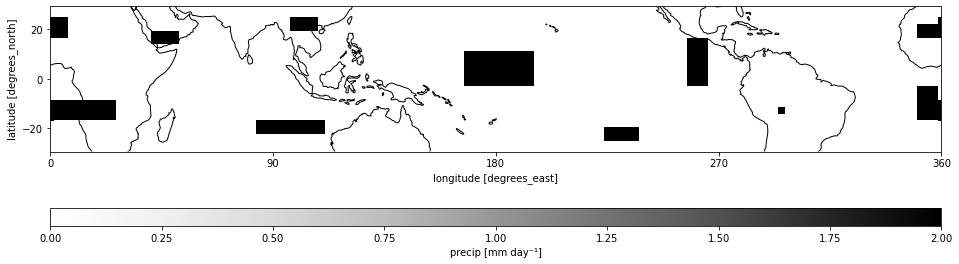

In [282]:
artScenes[:, :] = 0
artScenes[10:15, 60:70] = 2

artScenes[5:8, 0:10] = 2
artScenes[5:10, 125:] = 2

artScenes[17:20, 0:3] = 2
artScenes[17:19, 125:] = 2

artScenes[16:18, 15:19] = 2

artScenes[3:5, 30:40] = 2

artScenes[10:17, 92:95] = 2

artScenes[6:7, 105:106] = 2

artScenes[2:4, 80:85] = 2

artScenes[18:20, 35:39] = 2

plot_scene(artScenes, cmap='Greys')

## to calculate I_org

1. Find the distances between all object centroids
2. for each object find the distance to the closest object centroid
3. Calculate the theoretical Weibull random cumulative density function
4. Calculate the cumulative density function of the nearest neighbor distances
5. Cumulatively integrate the relationship

### 1. Find the distances between all object centroids (based on average lat, lon, accounting for objects across the boundary)

In [283]:
# Connect objects across boundary (objects that touch across lon=0, lon=360 boundary are the same object) (takes array(lat, lon))
def connect_boundary(array):
    s = np.shape(array)
    for row in np.arange(0,s[0]):
        if array[row,0]>0 and array[row,-1]>0:
            array[array==array[row,0]] = min(array[row,0],array[row,-1])
            array[array==array[row,-1]] = min(array[row,0],array[row,-1])

In [284]:
# Haversine formula (Great circle distance) (takes vectorized input)
def haversine_dist(lat1, lon1, lat2, lon2):

   # radius of earth in km
    R = 6371

    lat1 = np.deg2rad(lat1)                       
    lon1 = np.deg2rad(lon1-180)     
    lat2 = np.deg2rad(lat2)                       
    lon2 = np.deg2rad(lon2-180)

    # Haversine formula
    h = np.sin((lat2 - lat1)/2)**2 + np.cos(lat1)*np.cos(lat2) * np.sin((lon2 - lon1)/2)**2

    # distance from Haversine function:
    # (1) h = sin(theta/2)^2

    # central angle, theta:
    # (2) theta = d_{great circle} / R
    
    # (1) in (2) and rearrange for d gives
    # d = R * sin^-1(sqrt(h))*2 

    return 2 * R * np.arcsin(np.sqrt(h))

In [285]:
lat = scene.lat.data
lon = scene.lon.data
lonm,latm = np.meshgrid(lon,lat)
conv_threshold = 1
L = skm.label(artScenes.where(artScenes>=conv_threshold,0)>0, background=0,connectivity=2)

connect_boundary(L)
labels = np.unique(L)[1:]

In [286]:
labels

array([ 1,  2,  3,  5,  6,  7,  8,  9, 11], dtype=int32)

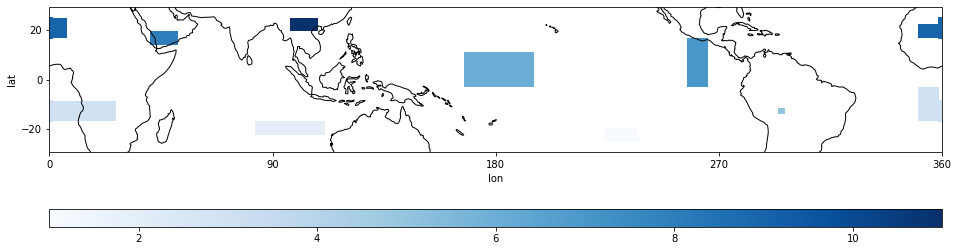

In [287]:
obj = L
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)

plot_scene(obj, 'Blues')

In [288]:
obj3d = np.stack([(L==label) for label in labels],axis=2)*1 # 3d matrix with each object in a scene being a binary 2d slice
np.max(obj3d)
np.shape(obj3d)

(22, 128, 9)

In [6]:
# for i in range(len(labels)):
#     obj = obj3d[:,:,i]
#     labelMatrix = xr.DataArray(
#         data=obj,
#         dims=['lat', 'lon'],
#         coords={'lat': scene.lat.data, 'lon': scene.lon.data}
#         )
#     obj = labelMatrix.where(labelMatrix>0)
#     plt.figure()
#     plot_scene(obj, 'Blues_r')

In [290]:
latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
lonm3d = np.expand_dims(lonm,axis=2) # used for broadcasting

In [291]:
o_lat = np.sum(obj3d * latm3d, axis=(0,1))/np.sum(obj3d, axis=(0,1))
o_lon = np.sum(obj3d * lonm3d, axis=(0,1))/np.sum(obj3d, axis=(0,1))

In [292]:
print(len(o_lat))
print(o_lat)

9
[-22.32487488 -19.53427315 -11.62755168 -12.55775642   4.18591986
   6.97653151  16.74366808  20.37145348  22.32487488]


In [293]:
print(len(o_lon))
print(o_lon)

9
[230.625    97.03125 126.5625  295.3125  181.40625 261.5625   46.40625
 143.4375  102.65625]


In [294]:
o_lon[7]

143.4375

In [295]:
np.shape(obj3d)

(22, 128, 9)

In [307]:
# lon for object crossing boundary
if np.sum(obj3d[:,0,:])>0 and np.sum(obj3d[:,-1,:])>0:
    print('scene has object on boundaries')

    for i in range(obj3d.shape[-1]):
        if ((obj3d[:,0,i] + obj3d[:,-1,i])>1).any():
            print('i = {} has object crossing boundary'.format(i))

            objLeft = obj3d[:,0:int(len(lon)/2),i]
            objRight = obj3d[:,int(len(lon)/2):None,i]

            objLeft_lon = objLeft*lonm[:,0:int(len(lon)/2)]
            objRight_lon = objRight*lonm[:,int(len(lon)/2):None]
            objLeft_lon360 = np.where(objLeft > 0, objLeft_lon + 360, 0)
            

            obj = np.hstack((objLeft, objRight))
            obj_lon = np.hstack((objLeft_lon360 + objRight_lon))
            o_lon[i] = np.sum(obj_lon)/np.sum(obj)

            if o_lon[i] >= 360:
                o_lon[i] = o_lon[i]-360


scene has object on boundaries
i = 2 has object crossing boundary
i = 7 has object crossing boundary


In [ ]:
# i=7
# print(((obj3d[:,0,i] + obj3d[:,-1,i])>1).any())
# i=8
# print(((obj3d[:,0,i] + obj3d[:,-1,i])>1).any())
#i = 7

True
False


In [ ]:
# a = np.array([0, 1, 0, 0, 0])
# print(a[0:int(len(a)/2)])
# print(a[int(len(a)/2):None])
# a = np.array([
#     [0, 1, 0],
#     [1, 0, 1],
#     [0, 1, 0]
# ])

# b = np.where(a > 0, a + 360, 0)
# print(b)

[0 1]
[0 0 0]


In [ ]:
# plt.figure()
# objLeft = obj3d[:,0:int(len(lon)/2),i]
# plt.pcolormesh(objLeft)

# plt.figure()
# objRight = obj3d[:,int(len(lon)/2):None,i]
# plt.pcolormesh(objRight)

# plt.figure()
# plt.pcolormesh(np.hstack((objLeft, objRight)))

In [308]:
print(len(o_lat))
print(o_lat)

9
[-22.32487488 -19.53427315 -11.62755168 -12.55775642   4.18591986
   6.97653151  16.74366808  20.37145348  22.32487488]


In [309]:
print(len(o_lon))
print(o_lon)

9
[230.625    97.03125   6.5625  295.3125  181.40625 261.5625   46.40625
 359.4375  102.65625]


In [310]:
o_lon[7]

359.4375

### 2. for each object find the distance, r_min, to the closest object centroid (len(r)=len(objects))

In [ ]:
r_min = []
for i in range(len(o_lon)):
    lat1 = o_lat[i]
    lon1 = o_lon[i]

    lat2 = o_lat
    lon2 = o_lon
    
    r = haversine_dist(lat1,lon1,lat2,lon2)
    r_min = np.append(r_min, np.nanmin(np.where(r>0, r, np.nan)))

In [ ]:
print(len(r_min))
print(r_min)

9
[4686.54564472 3277.47053149 3277.47053149 4316.16396695 4483.03426537
 4316.16396695 5895.27010923 4008.41024113 4216.47459815]


In [1]:
3277/171

19.16374269005848

### 3. Calculate the theoretical Weibull random cumulative density function

### 4. Calculate the cumulative density function of the nearest neighbor distances

### 5. Cumulatively integrate the relationship

In [ ]:
# for lamda divide by area of tropics

In [398]:
print(len(r_min))
print(r_min)

9
[4686.54564472 3277.47053149 3277.47053149 4316.16396695 4483.03426537
 4316.16396695 5895.27010923 4008.41024113 4216.47459815]


In [426]:
u_r_min, u_r_min_counts = np.unique(r_min, return_counts=True)
print(u_r_min)
print(u_r_min_counts)

[3277.47053149 4008.41024113 4216.47459815 4316.16396695 4483.03426537
 4686.54564472 5895.27010923]
[2 1 1 2 1 1 1]


In [427]:
def r_eff(area):
    return np.sqrt(area/np.pi)

In [5]:
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)
area_gridbox = np.mean(aream)
# gridbox_side = np.sqrt(area_gridbox)
radius_gridbox = r_eff(area_gridbox)
radius_gridbox

NameError: name 'lat' is not defined

In [429]:
lamda = len(r_min) / (len(scene.lat)*len(scene.lon))
lamda

0.0031960227272727275

In [430]:
u_r_min = u_r_min/radius_gridbox
u_r_min

array([19.10303861, 23.36338798, 24.57611023, 25.15715889, 26.12977778,
       27.31596258, 34.36112436])

In [360]:
# u_r_min = np.array([8,8,8,8,8,8,82])

In [431]:
-lamda * np.pi * u_r_min**2

array([ -3.6640774 ,  -5.48064123,  -6.06437466,  -6.35452243,
        -6.85537418,  -7.49191342, -11.85480636])

In [420]:
np.exp(-lamda * np.pi * u_r_min**2)

array([2.56278047e-02, 4.16665705e-03, 2.32421099e-03, 1.73886543e-03,
       1.05377726e-03, 5.57575062e-04, 7.10432818e-06])

In [432]:
weib_cdf = 1 - np.exp(-lamda * np.pi * u_r_min**2) #lambda = points per unit area (number of objects / maximmum number of objects)
weib_cdf

array([0.9743722 , 0.99583334, 0.99767579, 0.99826113, 0.99894622,
       0.99944242, 0.9999929 ])

In [433]:
data_cdf = np.cumsum(u_r_min_counts / np.sum(u_r_min_counts))
data_cdf

array([0.22222222, 0.33333333, 0.44444444, 0.66666667, 0.77777778,
       0.88888889, 1.        ])

In [434]:
weib_cdf = np.append(0, weib_cdf   )
weib_cdf = np.append(   weib_cdf, 1)
data_cdf = np.append(0, data_cdf   )
data_cdf = np.append(   data_cdf, 1)

In [ ]:
# If the theoretical Weibull distribution and the cumulative density function of nearest neighbour distance are one-to-one, the distribution is random. 
# If the cumulative density function is larger for a given distance, the distribution is clustered.

In [435]:
weib_cdf

array([0.        , 0.9743722 , 0.99583334, 0.99767579, 0.99826113,
       0.99894622, 0.99944242, 0.9999929 , 1.        ])

In [436]:
data_cdf

array([0.        , 0.22222222, 0.33333333, 0.44444444, 0.66666667,
       0.77777778, 0.88888889, 1.        , 1.        ])

Text(0, 0.5, 'Actual cdf')

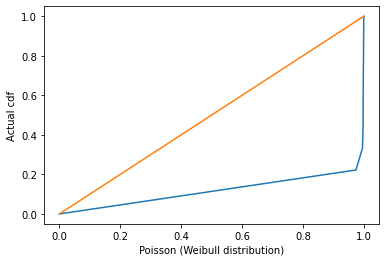

In [437]:
plt.plot(weib_cdf,data_cdf)
plt.plot(weib_cdf, weib_cdf)

plt.xlabel('Poisson (Weibull distribution)')
plt.ylabel('Actual cdf')

In [11]:
cdf_integral = scipy.integrate.cumtrapz(data_cdf, weib_cdf,initial=0)
cdf_integral[-1]

NameError: name 'data_cdf' is not defined

### Fulll calculation

In [12]:
# Connect objects across boundary (objects that touch across lon=0, lon=360 boundary are the same object) (takes array(lat, lon))
def connect_boundary(array):
    s = np.shape(array)
    for row in np.arange(0,s[0]):
        if array[row,0]>0 and array[row,-1]>0:
            array[array==array[row,0]] = min(array[row,0],array[row,-1])
            array[array==array[row,-1]] = min(array[row,0],array[row,-1])

In [17]:
# Haversine formula (Great circle distance) (takes vectorized input)
def haversine_dist(lat1, lon1, lat2, lon2):

   # radius of earth in km
    R = 6371

    lat1 = np.deg2rad(lat1)                       
    lon1 = np.deg2rad(lon1-180)     
    lat2 = np.deg2rad(lat2)                       
    lon2 = np.deg2rad(lon2-180)

    # Haversine formula
    h = np.sin((lat2 - lat1)/2)**2 + np.cos(lat1)*np.cos(lat2) * np.sin((lon2 - lon1)/2)**2

    # distance from Haversine function:
    # (1) h = sin(theta/2)^2

    # central angle, theta:
    # (2) theta = d_{great circle} / R
    
    # (1) in (2) and rearrange for d gives
    # d = R * sin^-1(sqrt(h))*2 

    return 2 * R * np.arcsin(np.sqrt(h))

In [18]:
def adjust_lonPosition(obj3d, o_lon):
    # lon for object crossing boundary
    if np.sum(obj3d[:,0,:])>0 and np.sum(obj3d[:,-1,:])>0:
        print('scene has object on boundaries')

        for i in range(obj3d.shape[-1]):
            if ((obj3d[:,0,i] + obj3d[:,-1,i])>1).any():
                print('i = {} has object crossing boundary'.format(i))

                objLeft = obj3d[:,0:int(len(lon)/2),i]
                objRight = obj3d[:,int(len(lon)/2):None,i]

                objLeft_lon = objLeft*lonm[:,0:int(len(lon)/2)]
                objRight_lon = objRight*lonm[:,int(len(lon)/2):None]
                objLeft_lon360 = np.where(objLeft > 0, objLeft_lon + 360, 0)
                

                obj = np.hstack((objLeft, objRight))
                obj_lon = np.hstack((objLeft_lon360 + objRight_lon))
                o_lon[i] = np.sum(obj_lon)/np.sum(obj)

                if o_lon[i] >= 360:
                    o_lon[i] = o_lon[i]-360

In [21]:
conv_threshold

<xarray.DataArray 'pr97' ()>
array(18.0409975)

In [64]:
rome_threshold = 0.1
rome_prctile = np.percentile(rome['rome'],rome_threshold)
x_rome= np.squeeze(np.argwhere(rome['rome'].data<=rome_prctile))
x_rome

array([ 858, 1376, 2790, 3044, 3045, 3058, 3110, 5373, 6763, 7581, 8972])

In [49]:
rome_threshold = 99.9
rome_prctile = np.percentile(rome['rome'],rome_threshold)
x_rome= np.squeeze(np.argwhere(rome['rome'].data>=rome_prctile))
x_rome

array([1861, 1925, 3714, 3718, 3719, 3721, 3723, 9897, 9917, 9918, 9919])

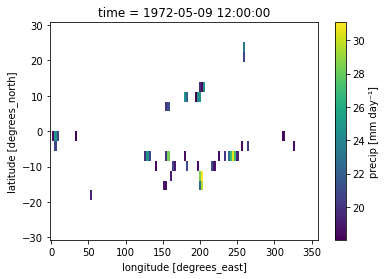

In [65]:
scene = ds[variable].isel(time=858)
scene.where(scene>=conv_threshold).plot()

In [66]:
# scene with convective objects
L = skm.label(scene.where(scene>=conv_threshold,0)>0, background=0,connectivity=2)

# Dimensions and area of domain
lat = scene.lat.data
lon = scene.lon.data
lonm,latm = np.meshgrid(lon,lat)
latm3d = np.expand_dims(latm,axis=2) # (for broadcasting) 
lonm3d = np.expand_dims(lonm,axis=2)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)
area_tropics = np.sum(aream)

# 3d matrix with each object in a scene being a binary 2d slice
connect_boundary(L)
labels = np.unique(L)[1:]
obj3d = np.stack([(L==label) for label in labels],axis=2)*1

# calculate latitude and longitude position (with special case for periodic lon boundary switching from 0 to 360)
o_lat = np.sum(obj3d * latm3d, axis=(0,1))/np.sum(obj3d, axis=(0,1))
o_lon = np.sum(obj3d * lonm3d, axis=(0,1))/np.sum(obj3d, axis=(0,1))
adjust_lonPosition(obj3d, o_lon)

# find distance to closest object iteratively for each object (len(dist_min) = len(obj)
dist_min = []
for i in range(len(o_lon)):
    lat1 = o_lat[i]
    lon1 = o_lon[i]

    lat2 = o_lat
    lon2 = o_lon
    
    dist = haversine_dist(lat1,lon1,lat2,lon2)
    dist_min = np.append(dist_min, np.nanmin(np.where(dist>0, dist, np.nan)))

u_dist_min, u_dist_min_counts = np.unique(dist_min, return_counts=True)

lamda = len(dist_min) / area_tropics*0.1 # number of points (centroids) per unit area
weib_cdf = 1 - np.exp(-lamda * np.pi * u_dist_min**2) # exponent of weib_cdf dimensionless
data_cdf = np.cumsum(u_dist_min_counts / np.sum(u_dist_min_counts))

weib_cdf = np.append(0, weib_cdf   )
weib_cdf = np.append(   weib_cdf, 1)
data_cdf = np.append(0, data_cdf   )
data_cdf = np.append(   data_cdf, 1)

cdf_integral = scipy.integrate.cumtrapz(data_cdf, weib_cdf, initial=0)
cdf_integral[-1]



0.9300949609963698

Text(0, 0.5, 'data cdf')

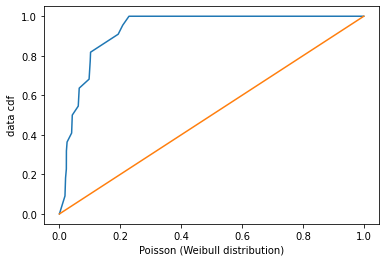

In [68]:
plt.figure()
plt.plot(weib_cdf,data_cdf)
plt.plot(weib_cdf, weib_cdf)

plt.xlabel('Poisson (Weibull distribution)')
plt.ylabel('data cdf')

In [ ]:
# def i_org(pairs, objects):
#     """I_org according to [Tompkins et al. 2017]"""
#     if not pairs.pairlist:
#         return np.nan
#     if len(pairs) == 1:
#         if pairs.partner1 == pairs.partner2:
#             return np.nan

#     distances = np.array(pairs.distance_regionprops())
#     dist_min = []

#     faster = True
#     if faster:
#         for cloud in objects:
#             dist_min.append(np.array([distances[i] for i, pair in enumerate(pairs.pairlist) if cloud in pair]).min())
#     else:
#         # maybe faster
#         for cloud in objects:
#             pair_in = np.isin(np.array(pairs.pairlist), cloud, assume_unique=True)
#             pair_one = pair_in[:, 0] + pair_in[:, 1]
#             dist_min.append(distances[pair_one].min())

#     # the theoretical Weibull-distribution for n particles
#     u_dist_min, u_dist_min_counts = np.unique(dist_min, return_counts=True)


    
#     lamda = len(objects) / 9841.  # one radar scan contains 9841 pixels
#     weib_cdf = 1 - np.exp(- lamda * np.pi * u_dist_min**2)

#     # the CDF from the actual data
#     data_cdf = np.cumsum(u_dist_min_counts / np.sum(u_dist_min_counts))

#     # compute the integral between Weibull CDF and data CDF
#     weib_cdf = np.append(0, weib_cdf   )
#     weib_cdf = np.append(   weib_cdf, 1)
#     data_cdf = np.append(0, data_cdf   )
#     data_cdf = np.append(   data_cdf, 1)
#     cdf_integral = scipy.integrate.cumtrapz(data_cdf, weib_cdf, initial=0)
#     return cdf_integral[-1]